In [ ]:
# --- CELL 1: IMPORTS AND ENVIRONMENT SETUP ---
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

# Metrics
from sklearn.metrics import accuracy_score, f1_score

# 1. Device Configuration
# Detect if a GPU is available to speed up training.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"  Device selected: {device}")

# 2. Reproducibility Setup (Crucial for comparison)
# We set a fixed seed (42) for all random number generators.
# This ensures that the 'random' split of data is identical every time we run this,
# allowing for a fair comparison with the GNN model which also uses seed 42.
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"  Random seed fixed to {SEED} for reproducibility.")

  Device selected: cuda
  Random seed fixed to 42 for reproducibility.


In [ ]:
# Link drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("  Google Drive già montato.")

Mounted at /content/drive


In [ ]:
# --- CELL 2: CONFIGURATION (STRICTLY ORIGINAL HYPERPARAMETERS) ---

CONFIG = {
    # --- Paths ---
    "input_dir": '/content/drive/MyDrive/AML_Project/Extension/step1_HiERO/steps_v4',
    "annotation_csv": '/content/drive/MyDrive/AML_Project/annotations-main/annotation_csv/error_annotations.csv',
    # output dir
    "save_dir": '/content/drive/MyDrive/AML_Project/Extension/step_2_baseline/models_gnn_split_bsv2',
    "SPLIT_JSON_PATH" : '/content/drive/MyDrive/AML_Project/Extension/step_2_baseline/models_gnn_split_bsv2/master_split_ids.json', # saving dataset split to reuse it in GNN

    # --- Model Hyperparameters (From "Optimized Training" cell) ---
    "input_dim": 256,
    "model_dim": 128,
    "nhead": 4,
    "num_layers": 2,
    "dropout": 0.3,
    "max_seq_len": 300,

    # --- Training Hyperparameters (From "Optimized Training" cell) ---
    "batch_size": 16,
    "epochs": 80,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "patience": 10,

    "device": device
}

# Creazione cartella se non esiste
os.makedirs(CONFIG["save_dir"], exist_ok=True)

print("  Configuration loaded")
print(f"   LR: {CONFIG['learning_rate']} | Epochs: {CONFIG['epochs']} | Batch: {CONFIG['batch_size']}")

  Configuration loaded
   LR: 0.0001 | Epochs: 80 | Batch: 16


In [ ]:
# --- CELL 3: DATASET AND DATA PREPARATION ---

class RecipeDataset(Dataset):
    """
    Custom Dataset to load pre-computed video features stored in .npz files.
    """
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the feature file (numpy array)
        # expected shape: (Sequence_Length, Input_Dim)
        data = np.load(self.file_paths[idx])
        embeddings = data['embeddings']

        # Safety check: Handle rare cases of empty video features
        if embeddings.shape[0] == 0:
            embeddings = np.zeros((1, 256)) # Return a dummy zero vector

        return torch.tensor(embeddings, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

def collate_fn(batch):
    """
    Custom collate function to handle batches of videos with different lengths.
    It applies padding so all sequences in a batch have the same length.
    """
    embeddings, labels = zip(*batch)

    # Pad sequences with 0.0 to the length of the longest sequence in the batch
    # batch_first=True -> Output shape: (Batch_Size, Max_Seq_Len, Feature_Dim)
    embeddings_padded = pad_sequence(embeddings, batch_first=True, padding_value=0.0)

    # Create a mask to tell the Transformer which parts are real data (1) and which are padding (0)
    # Check if the feature vector is not all zeros
    mask = (torch.sum(embeddings_padded, dim=2) != 0).float()

    labels = torch.stack(labels)
    return embeddings_padded, mask, labels

def prepare_data(config):
    """
    Loads all file paths and their corresponding labels.
    CRITICAL: Sorts files to ensure alignment with the GNN notebook split.
    """
    print("Preparing Data...")

    # 1. Load Annotations
    if not os.path.exists(config["annotation_csv"]):
        raise FileNotFoundError(f"Missing CSV: {config['annotation_csv']}")

    error_df = pd.read_csv(config["annotation_csv"])

    # Clean up string columns to avoid mismatch issues
    error_df['recording_id'] = error_df['recording_id'].astype(str).str.strip()
    error_df['has_errors'] = error_df['has_errors'].astype(str).str.strip().str.lower()

    # Create a set of IDs that contain mistakes for fast lookup
    mistake_ids = set(error_df[error_df['has_errors'] == 'true']['recording_id'].unique())

    # 2. Load File Paths (SORTED)
    # Using sorted() is MANDATORY here.
    # It ensures the order of files matches the sorted(os.listdir) used in the GNN notebook.
    all_files = sorted(glob.glob(os.path.join(config["input_dir"], '*_steps.npz')))

    if not all_files:
        raise ValueError(f"No files found in {config['input_dir']}")

    file_paths = []
    labels = []

    for fpath in all_files:
        filename = os.path.basename(fpath)
        # Extract Video ID: e.g., '10_1_steps.npz' -> '10_1'
        video_id = filename.replace('_steps.npz', '')

        file_paths.append(fpath)

        # Assign Label: 1 if mistake, 0 if normal
        if video_id in mistake_ids:
            labels.append(1)
        else:
            labels.append(0)

    print(f"  Data ready. Total Videos: {len(file_paths)}")
    print(f"   Normal Videos (0): {labels.count(0)}")
    print(f"   Mistake Videos (1): {labels.count(1)}")

    return file_paths, labels

In [ ]:
# --- CELL 4: TRANSFORMER MODEL ARCHITECTURE ---

class BaselineTransformer(nn.Module):
    def __init__(self, config):
        super(BaselineTransformer, self).__init__()
        self.config = config

        # 1. Input Projection
        # Projects the high-dimensional video features (e.g., 256) down to the model dimension (e.g., 128)
        self.input_proj = nn.Linear(config["input_dim"], config["model_dim"])

        # 2. Learnable Positional Encoding
        # Adds information about the order of frames.
        # Shape: (1, Max_Len, Model_Dim) to allow broadcasting across batch
        self.pos_encoder = nn.Parameter(torch.randn(1, config["max_seq_len"], config["model_dim"]))

        # 3. Transformer Encoder
        # The core processing unit. batch_first=True means input is (Batch, Seq, Feature)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config["model_dim"],
            nhead=config["nhead"],
            dropout=config["dropout"], # Apply dropout inside transformer
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=config["num_layers"])

        # 4. Classifier Head (Optimized with Dropout)
        # Dropout -> Linear -> ReLU -> Dropout -> Linear
        self.classifier = nn.Sequential(
            nn.Dropout(config["dropout"]),
            nn.Linear(config["model_dim"], 64),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(64, 1) # Binary classification output
        )

    def forward(self, x, mask=None):
        # x shape: (Batch_Size, Seq_Len, Input_Dim)

        # 1. Input Projection
        x = self.input_proj(x)

        # 2. Sequence Truncation (if longer than max_seq_len)
        seq_len = x.size(1)
        if seq_len > self.config["max_seq_len"]:
            x = x[:, :self.config["max_seq_len"], :]
            seq_len = self.config["max_seq_len"]
            if mask is not None:
                mask = mask[:, :self.config["max_seq_len"]]

        # Add Positional Encoding
        x = x + self.pos_encoder[:, :seq_len, :]

        # 3. Transformer Encoder Pass
        # Create padding mask: True indicates padding positions to ignore
        padding_mask = (mask == 0) if mask is not None else None
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)

        # 4. Masked Mean Pooling (Original Logic)
        # Average only over valid frames, ignoring padding zeros.
        if mask is not None:
            # Weighted sum (features * mask) / Number of valid frames (sum of mask)
            # +1e-6 added to prevent division by zero
            x = torch.sum(x * mask.unsqueeze(-1), dim=1) / (torch.sum(mask, dim=1, keepdim=True) + 1e-6)
        else:
            # Fallback (should not happen with our collate_fn)
            x = torch.mean(x, dim=1)

        # 5. Classification Head
        # Passes through: Dropout -> Linear -> ReLU -> Dropout -> Linear
        logits = self.classifier(x)

        return logits.squeeze(1)

In [ ]:
# --- CELL 5: HELPER FUNCTIONS (Evaluation & Plotting) ---

def evaluate_model(model, data_loader, criterion, device):
    """
    Evaluates the model on a given dataset (Validation or Test) without updating weights.
    Returns: Average Loss, Accuracy, and F1-Score.
    """
    model.eval() # Set model to evaluation mode (disables Dropout)

    total_loss = 0.0
    all_preds = []
    all_labels = []

    # Disable gradient calculation to save memory and computation
    with torch.no_grad():
        for batch_emb, batch_mask, batch_y in data_loader:
            # Move data to the configured device (GPU/CPU)
            batch_emb = batch_emb.to(device)
            batch_mask = batch_mask.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            # We pass the mask so the model knows which timesteps are padding
            outputs = model(batch_emb, batch_mask)

            # Compute loss
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            # Convert logits to probabilities (Sigmoid) and then to binary predictions (0 or 1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Store predictions and labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Calculate aggregate metrics over the entire dataset
    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return avg_loss, acc, f1

def plot_training_history(history, save_dir):
    """
    Plots the Loss and Accuracy curves for Training and Validation.
    Saves the image to the specified directory.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # --- Plot 1: Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Plot 2: Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot to file
    plot_path = os.path.join(save_dir, 'training_metrics.png')
    plt.savefig(plot_path)
    plt.show()
    print(f" Training history plot saved to: {plot_path}")

  Starting Baseline Training...
Preparing Data...
  Data ready. Total Videos: 384
   Normal Videos (0): 164
   Mistake Videos (1): 220
  Dataset Split -> Train: 268 | Val: 57 | Test: 59
  Saving Split IDs to /content/drive/MyDrive/AML_Project/Extension/step_2_baseline/models_gnn_split_bsv2/master_split_ids.json...
  Split Master saved

  Starting Training Loop...
Epoch  |  Tr Loss  | Val Loss  |  Tr Acc   |  Val Acc  |  Val F1   | Status
-------------------------------------------------------------------------------------
  1    |  0.6843   |  0.6912   |  0.5448   |  0.5614   |  0.7191   |   Best
  2    |  0.6865   |  0.6901   |  0.5597   |  0.5614   |  0.7191   | 
  3    |  0.6618   |  0.6911   |  0.5858   |  0.5614   |  0.7191   | 
  4    |  0.6615   |  0.6896   |  0.5933   |  0.5614   |  0.6575   | 
  5    |  0.6514   |  0.6974   |  0.6418   |  0.5439   |  0.6977   | 
  6    |  0.6190   |  0.6812   |  0.6679   |  0.6491   |  0.6970   | 
  7    |  0.6263   |  0.6900   |  0.6567   |  

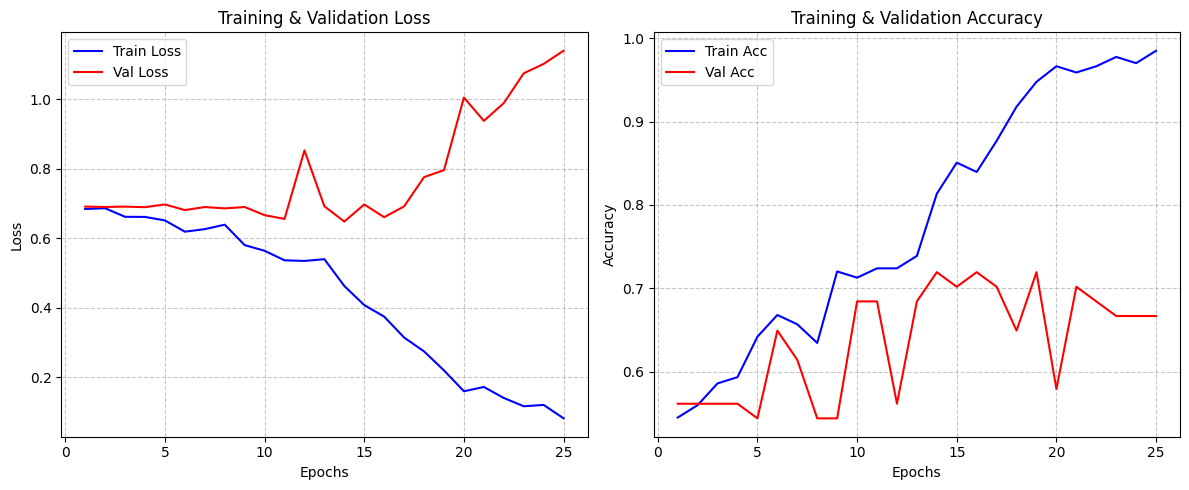

 Training history plot saved to: /content/drive/MyDrive/AML_Project/Extension/step_2_baseline/models_gnn_split_bsv2/training_metrics.png


In [ ]:
# --- CELL 6: MAIN EXECUTION ---

def main():
    print("  Starting Baseline Training...")

    # 1. Prepare Data
    # Load file paths and labels (Sorted to match GNN)
    paths, labels = prepare_data(CONFIG)

    # Create the full dataset
    full_dataset = RecipeDataset(paths, labels)

    # 2. Split Dataset (Identical to GNN logic)
    # Calculate sizes for 70% Train, 15% Val, 15% Test
    total_len = len(full_dataset)
    train_perc, val_perc = 0.70, 0.15

    train_size = int(train_perc * total_len)
    val_size = int(val_perc * total_len)
    test_size = total_len - train_size - val_size

    print(f"  Dataset Split -> Train: {train_size} | Val: {val_size} | Test: {test_size}")

    # Perform the split using a Generator with fixed seed 42.
    # This guarantees that index 0 goes to the same set as in the GNN notebook.
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"  Saving Split IDs to {CONFIG["SPLIT_JSON_PATH"]}...")

    split_map = {'train': [], 'val': [], 'test': []}

    # Helper per estrarre ID dai Subset
    def extract_ids(subset):
        ids = []
        # subset.indices sono gli indici originali nel full_dataset
        for idx in subset.indices:
            path = full_dataset.file_paths[idx]
            # Estrai '10_1' da '.../10_1_steps.npz'
            vid_id = os.path.basename(path).replace('_steps.npz', '')
            ids.append(vid_id)
        return ids

    split_map['train'] = extract_ids(train_dataset)
    split_map['val']   = extract_ids(val_dataset)
    split_map['test']  = extract_ids(test_dataset)

    with open(CONFIG["SPLIT_JSON_PATH"], 'w') as f:
        json.dump(split_map, f)
    print("  Split Master saved")

    # 3. Create DataLoaders
    # Shuffle only for training. Validation and Test must be deterministic.
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, collate_fn=collate_fn)

    # 4. Initialize Model, Loss, and Optimizer
    model = BaselineTransformer(CONFIG).to(CONFIG["device"])

    # BCEWithLogitsLoss combines Sigmoid + BCELoss (numerically more stable)
    criterion = nn.BCEWithLogitsLoss()

    # AdamW optimizer is generally better than Adam for Transformers
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG["learning_rate"],
        weight_decay=CONFIG["weight_decay"]
    )

    # 5. Training Loop
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    best_val_f1 = 0.0
    patience_counter = 0 # For Early Stopping

    print("\n  Starting Training Loop...")
    print(f"{'Epoch':^6} | {'Tr Loss':^9} | {'Val Loss':^9} | {'Tr Acc':^9} | {'Val Acc':^9} | {'Val F1':^9} | {'Status'}")
    print("-" * 85)

    for epoch in range(CONFIG["epochs"]):
        model.train() # Enable Dropout
        train_loss_sum = 0
        train_correct = 0
        train_total = 0

        for batch_emb, batch_mask, batch_y in train_loader:
            # Move batch to device
            batch_emb, batch_mask, batch_y = batch_emb.to(CONFIG["device"]), batch_mask.to(CONFIG["device"]), batch_y.to(CONFIG["device"])

            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(batch_emb, batch_mask)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            # Track training metrics
            train_loss_sum += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_correct += (preds == batch_y).sum().item()
            train_total += batch_y.size(0)

        # Calculate Epoch Metrics
        avg_train_loss = train_loss_sum / len(train_loader)
        avg_train_acc = train_correct / train_total

        # Evaluate on Validation Set
        val_loss, val_acc, val_f1 = evaluate_model(model, val_loader, criterion, CONFIG["device"])

        # Update History
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Checkpointing & Early Stopping
        status = ""
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), os.path.join(CONFIG["save_dir"], 'best_model.pth'))
            status = "  Best"
        else:
            patience_counter += 1

        print(f"{epoch+1:^6} | {avg_train_loss:^9.4f} | {val_loss:^9.4f} | {avg_train_acc:^9.4f} | {val_acc:^9.4f} | {val_f1:^9.4f} | {status}")

        if patience_counter >= CONFIG["patience"]:
            print(f"\n  Early Stopping triggered after {epoch+1} epochs.")
            break

    # 6. Final Evaluation on Test Set
    print("\nLoading Best Model for FINAL TEST Evaluation...")
    # Load the weights of the best performing model on validation
    model.load_state_dict(torch.load(os.path.join(CONFIG["save_dir"], 'best_model.pth')))

    test_loss, test_acc, test_f1 = evaluate_model(model, test_loader, criterion, CONFIG["device"])

    print("-" * 50)
    print(f"  FINAL TEST RESULTS:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print("-" * 50)

    # 7. Plot Metrics
    plot_training_history(history, CONFIG["save_dir"])

# Entry point
if __name__ == "__main__":
    main()

🕵️‍♂️ Verifying Dataset Split consistency...
Preparing Data...
  Data ready. Total Videos: 384
   Normal Videos (0): 164
   Mistake Videos (1): 220

📊 SPLIT STATISTICS (Check if these match GNN):
   TRAIN: Total 268 | Normal: 113 | Mistake: 155
   VAL:   Total 57  | Normal: 25  | Mistake: 32
   TEST:  Total 59  | Normal: 26  | Mistake: 33


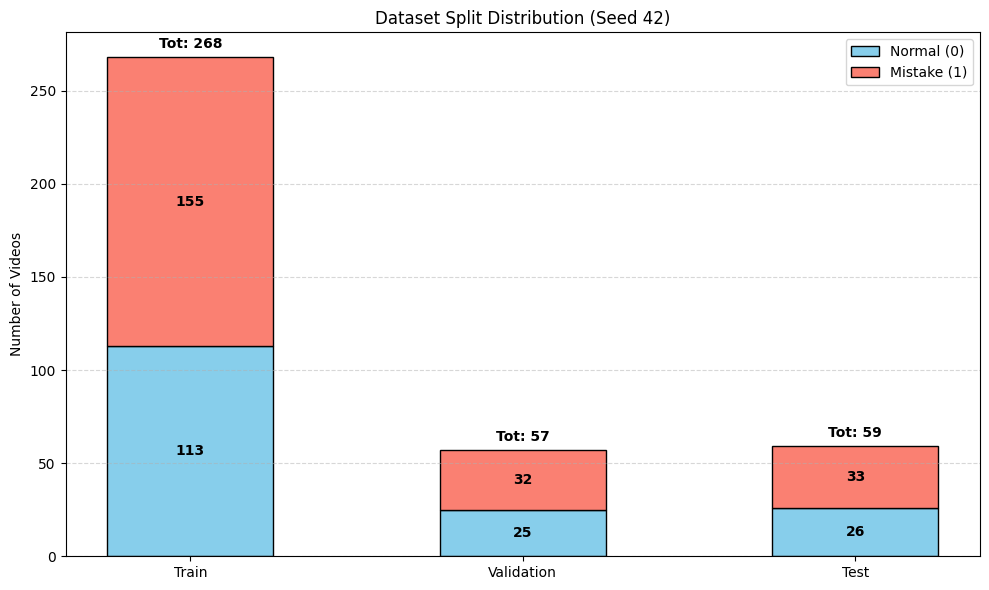

In [ ]:
# --- CELL 7: DATASET VERIFICATION PLOT ---

def verify_and_plot_split():
    print(" Verifying Dataset Split consistency...")

    # 1. Re-load and Re-split (Deterministic with Seed 42)
    # Note: We repeat this to ensure we are analyzing exactly what the model sees
    paths, labels = prepare_data(CONFIG)
    full_dataset = RecipeDataset(paths, labels)

    total_len = len(full_dataset)
    train_size = int(0.70 * total_len)
    val_size = int(0.15 * total_len)
    test_size = total_len - train_size - val_size

    train_subset, val_subset, test_subset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # 2. Count Classes in each Split
    # Helper to count 0s and 1s in a Subset
    def get_counts(subset, all_labels):
        indices = subset.indices
        subset_labels = [all_labels[i] for i in indices]
        normal = subset_labels.count(0)
        mistake = subset_labels.count(1)
        return normal, mistake

    tr_n, tr_m = get_counts(train_subset, labels)
    val_n, val_m = get_counts(val_subset, labels)
    te_n, te_m = get_counts(test_subset, labels)

    # 3. Print Exact Numbers (Compare these with GNN Notebook!)
    print("\n SPLIT STATISTICS (Check if these match GNN):")
    print(f"   TRAIN: Total {len(train_subset)} | Normal: {tr_n} | Mistake: {tr_m}")
    print(f"   VAL:   Total {len(val_subset)}  | Normal: {val_n}  | Mistake: {val_m}")
    print(f"   TEST:  Total {len(test_subset)}  | Normal: {te_n}  | Mistake: {te_m}")

    # 4. Plot Stacked Bar Chart
    splits = ['Train', 'Validation', 'Test']
    normals = [tr_n, val_n, te_n]
    mistakes = [tr_m, val_m, te_m]

    x = np.arange(len(splits))
    width = 0.5

    plt.figure(figsize=(10, 6))
    p1 = plt.bar(x, normals, width, label='Normal (0)', color='skyblue', edgecolor='black')
    p2 = plt.bar(x, mistakes, width, bottom=normals, label='Mistake (1)', color='salmon', edgecolor='black')

    plt.ylabel('Number of Videos')
    plt.title('Dataset Split Distribution (Seed 42)')
    plt.xticks(x, splits)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add counts inside bars
    for i in range(len(splits)):
        plt.text(i, normals[i]/2, str(normals[i]), ha='center', va='center', fontweight='bold')
        plt.text(i, normals[i] + mistakes[i]/2, str(mistakes[i]), ha='center', va='center', fontweight='bold')
        plt.text(i, normals[i] + mistakes[i] + 5, f"Tot: {normals[i]+mistakes[i]}", ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG["save_dir"], 'dataset_split_verification.png'))
    plt.show()

# Run Verification
if __name__ == "__main__":
    verify_and_plot_split()